In [1]:
import os
import sys
import time
import tqdm
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
sys.path.append('/content/drive/MyDrive/cms-main')

In [3]:
from src.utils import  *


In [4]:
RAW_DATA_PATH = '/content/drive/MyDrive/cms-main/dataset/raw_data'
PROCESSED_DATA_PATH = '/content/drive/MyDrive/cms-main/dataset/raw_data'


#File Loading
raw_data_files = os.listdir(RAW_DATA_PATH)
processed_data_files = os.listdir(PROCESSED_DATA_PATH)
raw_data = [pd.read_csv(os.path.join(RAW_DATA_PATH, raw_data_files[i])) for i in range(len(raw_data_files)) if raw_data_files[i].endswith('csv')]
processed_data =  [pd.read_csv(os.path.join(PROCESSED_DATA_PATH, processed_data_files[i])) for i in range(len(processed_data_files)) if processed_data_files[i].endswith('csv')]
metadata = pd.read_excel(os.path.join(RAW_DATA_PATH, 'MetaData.xlsx'))

In [5]:
#Labeling - Faulted detected sensors / not detected sensors
df = pd.concat([raw_data[i] for i in range(len(raw_data))]).drop_duplicates()
fault_detected = [378, 381, 382, 386, 387, 389, 420, 591, 592, 593, 1113, 2489, 2497]
fault_not_detected = set(df.MeasureId.value_counts().index)- set(fault_detected)

In [6]:
# filter out the indexes where the machine was at a rest
# 구현 요청 사항 : 04.27 14:00 이상치로 판별난 outlier_of_12000에서, 앞뒤 구간 200개 정도씩을 이상치로 추가 포함하고 싶음.
df_598 = df[df.MeasureId==600].reset_index().copy()
preprocessed_df = rolling_processor(df_598, window_size=168, std_window=36, envelope_window=24).reset_index()
preprocessed_df.DateTime=pd.to_datetime(preprocessed_df.DateTime)


In [7]:

outlier_of_12000=preprocessed_df[preprocessed_df.std36<0.04].index


df_961 = df[df.MeasureId==961].reset_index().copy()
preprocessed_df = rolling_processor(df_961, window_size=168, std_window=36, envelope_window=24).reset_index()
preprocessed_df.DateTime=pd.to_datetime(preprocessed_df.DateTime)

outlier_of_10000=preprocessed_df[preprocessed_df.std36<0.05].index

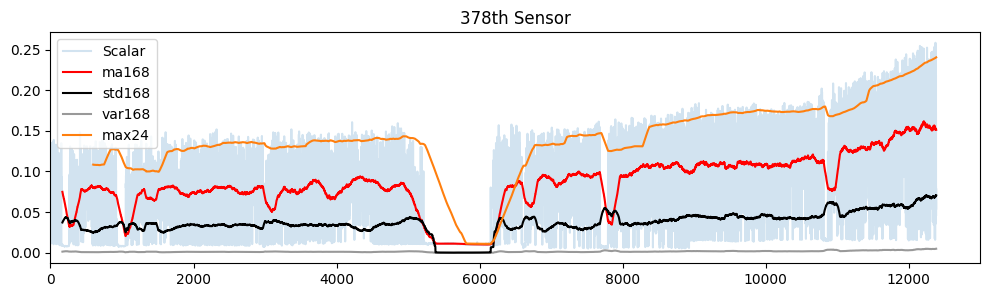

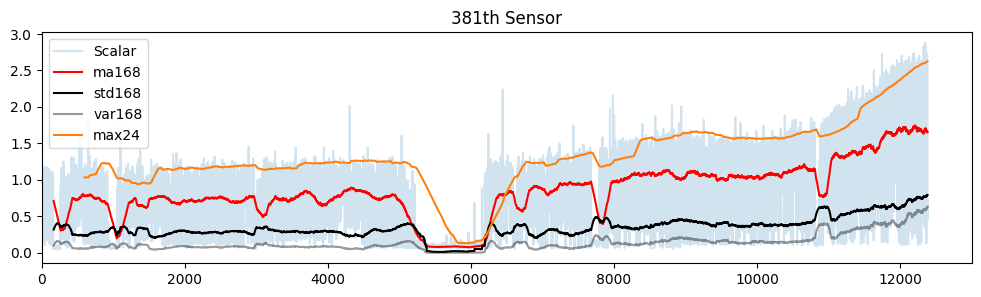

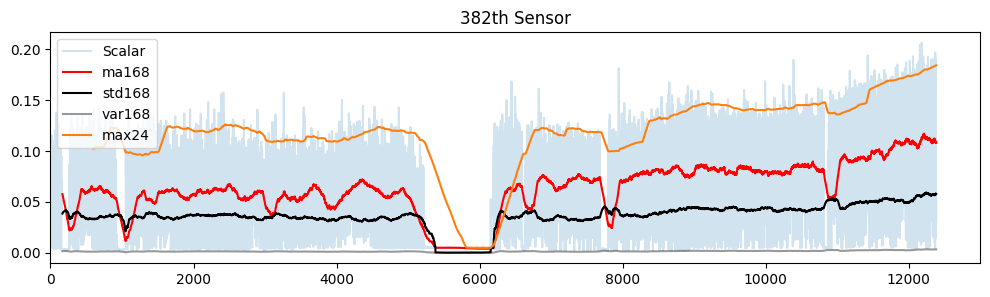

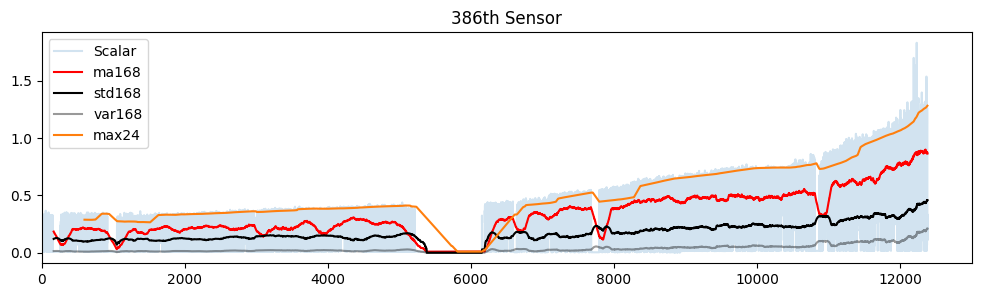

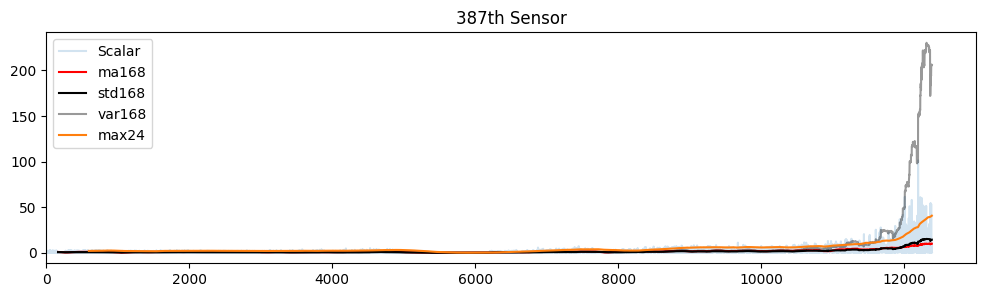

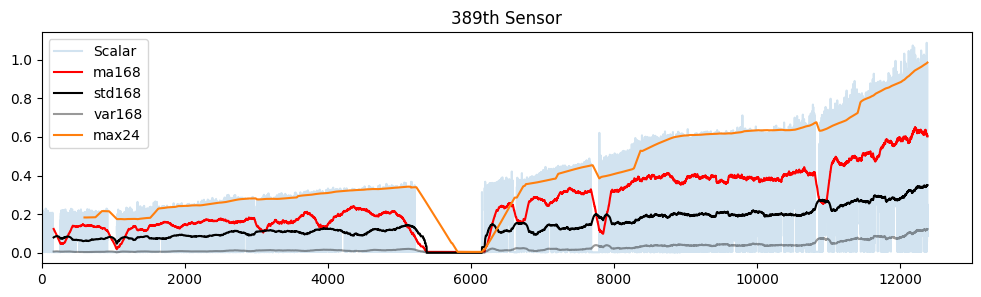

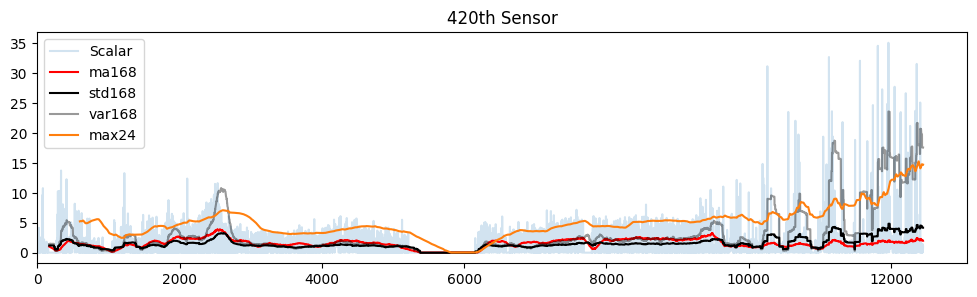

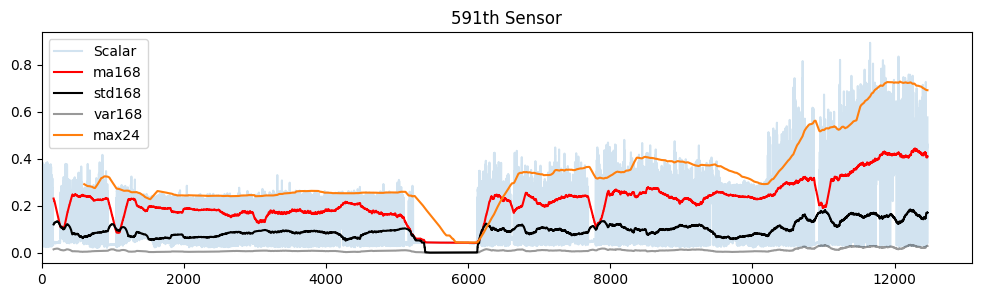

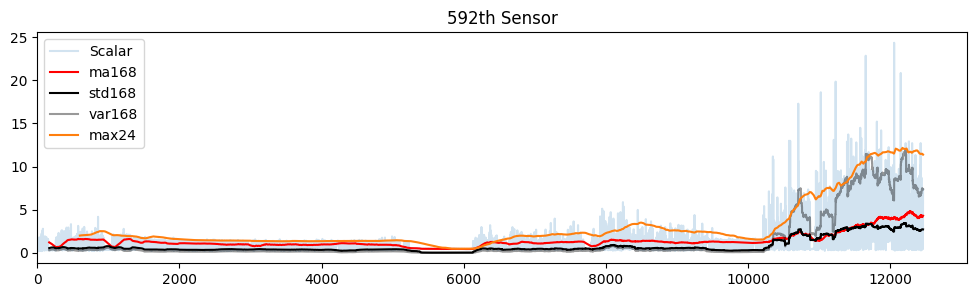

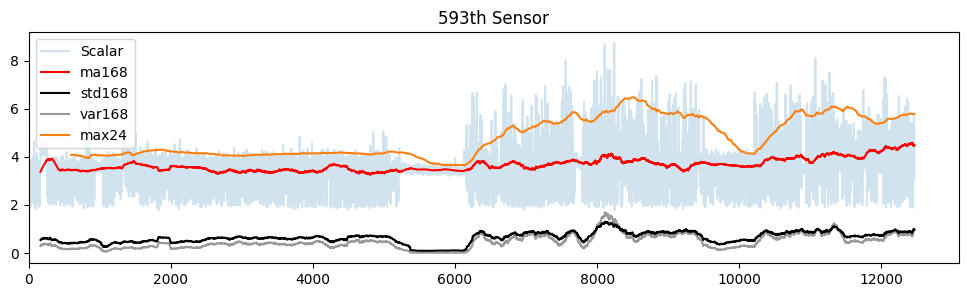

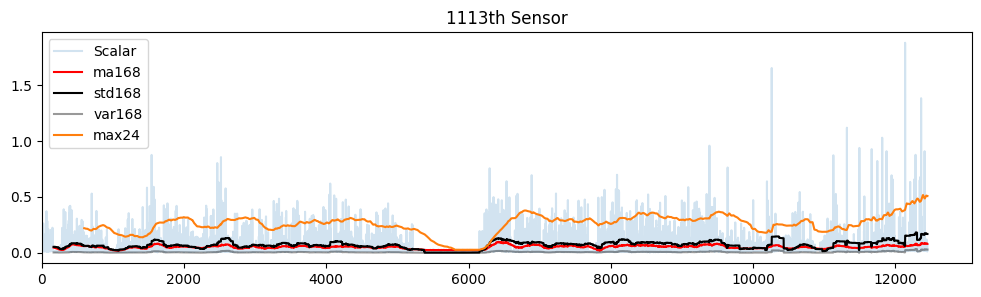

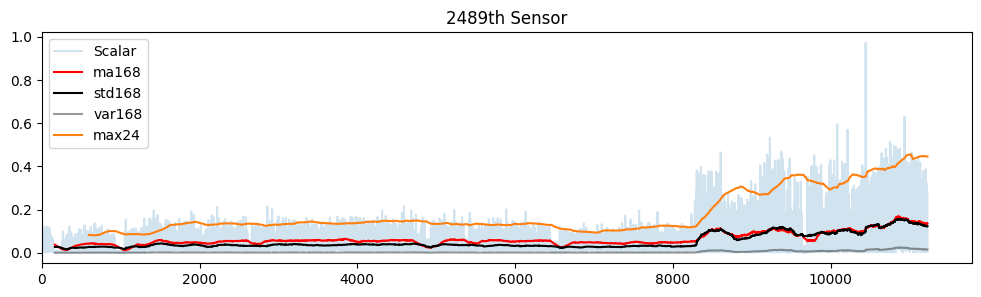

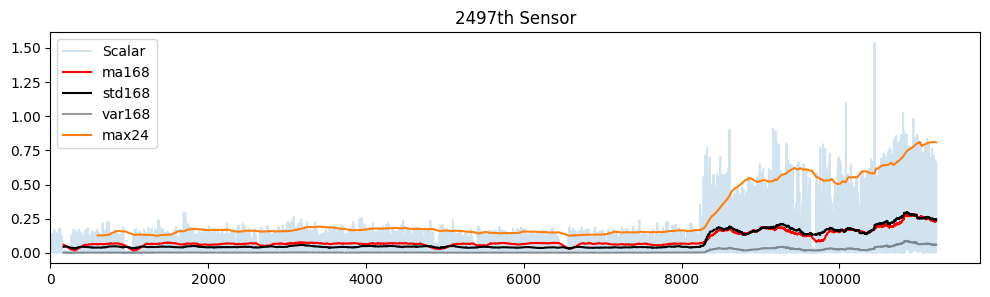

In [8]:
fault_df_dict=df_divider(df, fault_detected)
normal_df_dict=df_divider(df, fault_not_detected)
for key, val in fault_df_dict.items():
    visualize_MA_with_std(df=val, measure_id=key, window_size=[168], std_window= 168, envelope_window=24)

In [9]:
def data_cutter(df, start_point):
    return df.iloc[start_point:,:]
fault_df_dict_train = {}
fault_df_dict_test = {}
normal_df_dict_train = {}
normal_df_dict_test = {}
#START_POINT=9000
fault_df_dict=df_divider(df, fault_detected)
normal_df_dict=df_divider(df, fault_not_detected)
for i, fault_df in fault_df_dict.items():
    fault_df_dict[i]=normalizer(not_operating_condition_exterminator(fault_df, outlier_of_10000, outlier_of_12000))
    fault_df_dict[i]=rolling_processor(fault_df_dict[i], window_size=168, std_window=168, envelope_window=48)
    fault_df_dict[i]["mean_plus_std_72"] = fault_df_dict[i]['Scalar'].rolling(72).mean() + 1.5*fault_df_dict[i]['Scalar'].rolling(72).std()
    fault_df_dict_train[i] = fault_df_dict[i].iloc[:int(len(fault_df_dict[i])*0.92)].reset_index(drop=True)
    fault_df_dict_test[i]=data_cutter(fault_df_dict[i], int(len(fault_df_dict[i])*0.92)).reset_index(drop=True)
    fault_df_dict_train[i]['time_idx']=fault_df_dict_train[i].index
    fault_df_dict_test[i]['time_idx']=fault_df_dict_test[i].index
    
for i, normal_df in normal_df_dict.items():
    normal_df_dict[i]=normalizer(not_operating_condition_exterminator(normal_df, outlier_of_10000, outlier_of_12000))
    normal_df_dict[i]=rolling_processor(normal_df_dict[i], window_size=168, std_window=168, envelope_window=48)
    normal_df_dict[i]["mean_plus_std_72"] = normal_df_dict[i]['Scalar'].rolling(72).mean() + 1.5*normal_df_dict[i]['Scalar'].rolling(72).std()
    normal_df_dict_train[i] = normal_df_dict[i].iloc[:int(len(normal_df_dict[i])*0.92)].reset_index(drop=True)
    normal_df_dict_test[i]=data_cutter(normal_df_dict[i], int(len(normal_df_dict[i])*0.92)).reset_index(drop=True)
    normal_df_dict_train[i]['time_idx']=normal_df_dict_train[i].index
    normal_df_dict_test[i]['time_idx']=normal_df_dict_test[i].index

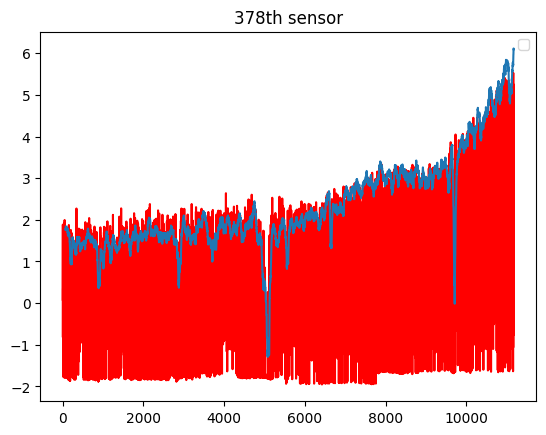

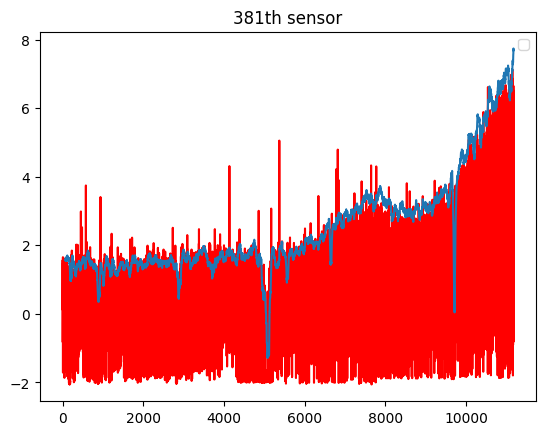

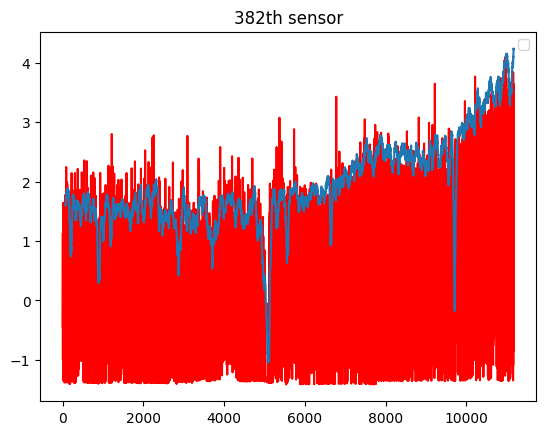

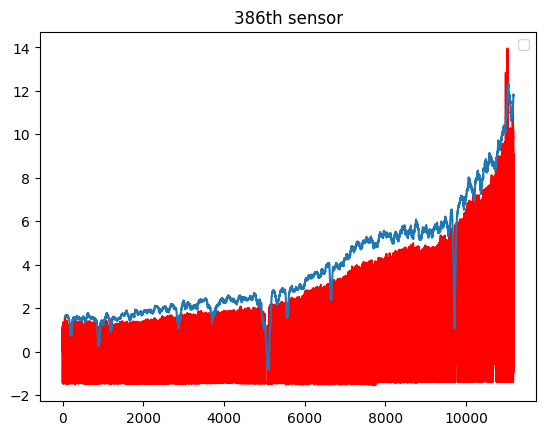

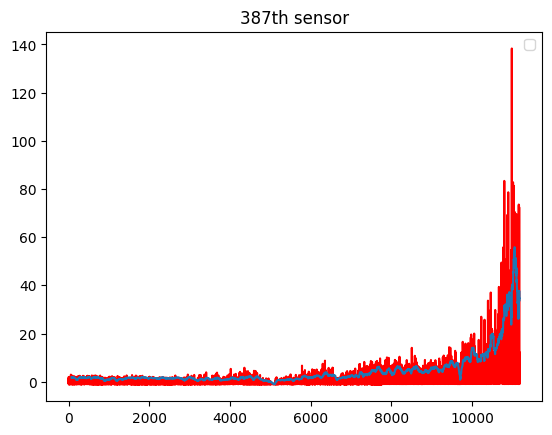

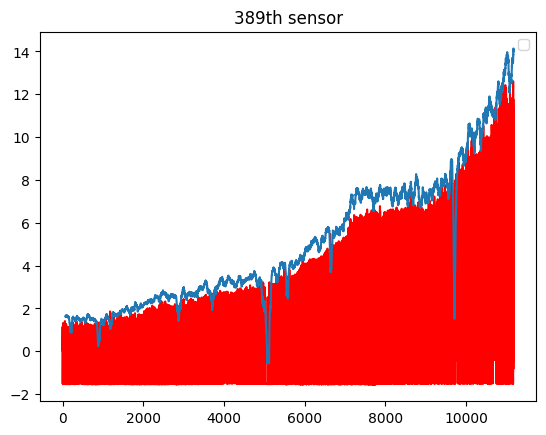

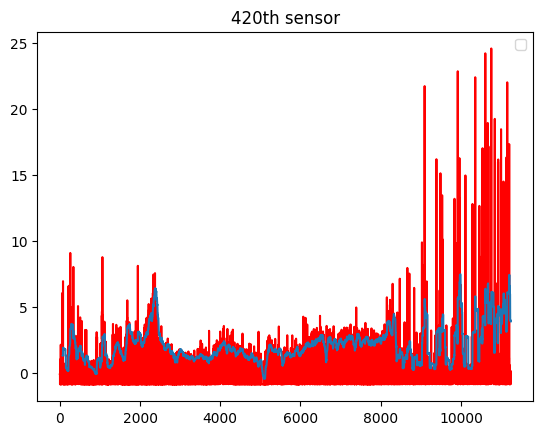

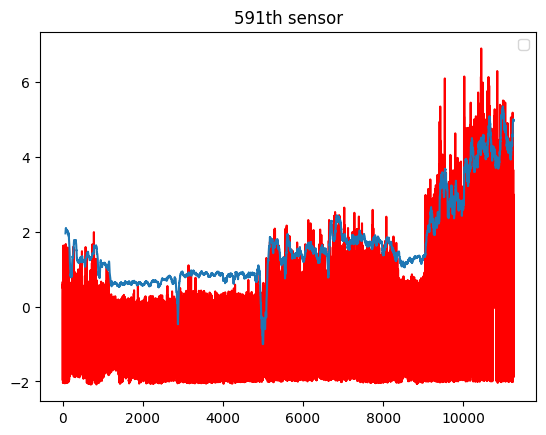

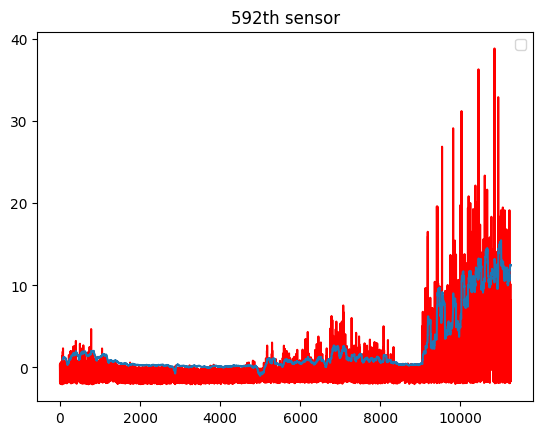

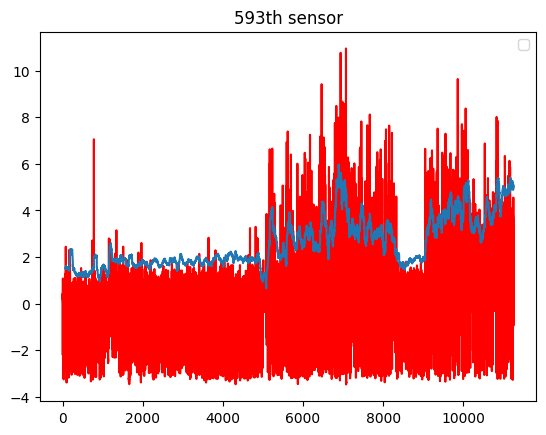

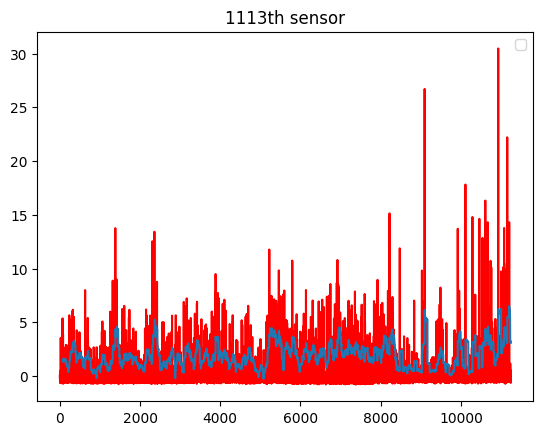

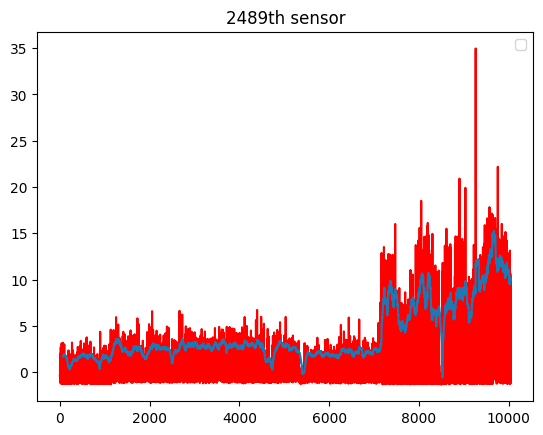

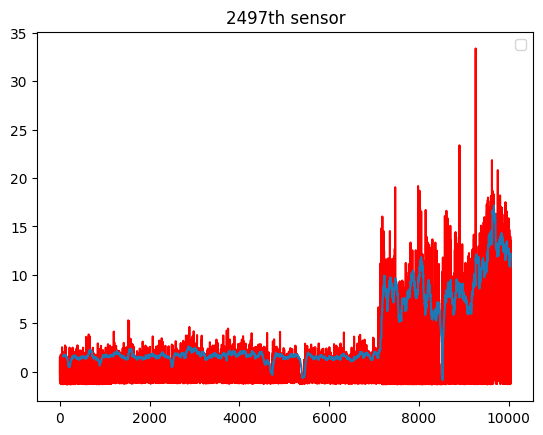

In [10]:
for key, _ in fault_df_dict.items():
  fig, ax = plt.subplots()
  ax.plot(fault_df_dict[key][["Scalar"]],color = "red")
  ax.plot(fault_df_dict[key][["mean_plus_std_72"]])
  ax.set_title("{}th sensor".format(key))
  ax.legend()
  plt.show()

# 지수함수 피팅(아래쪽 이상치 제거 필요)

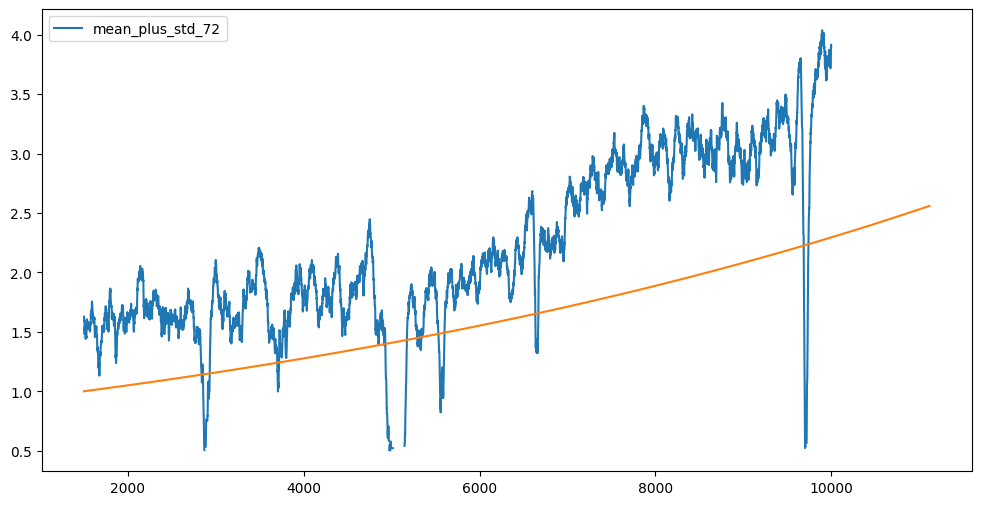

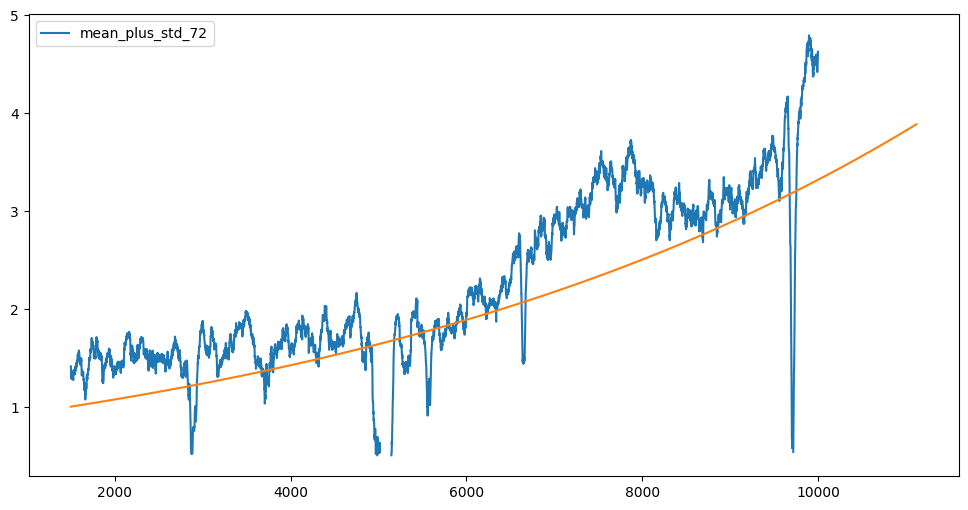

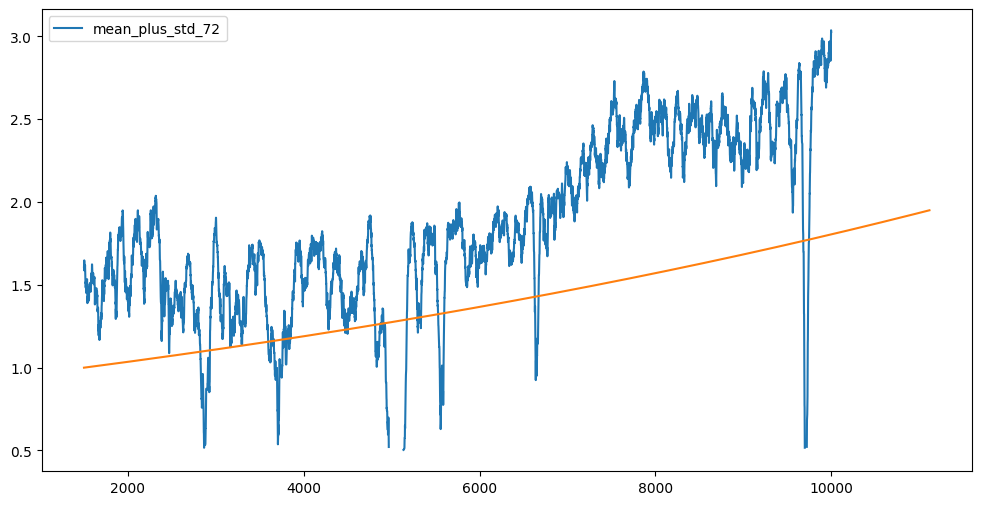

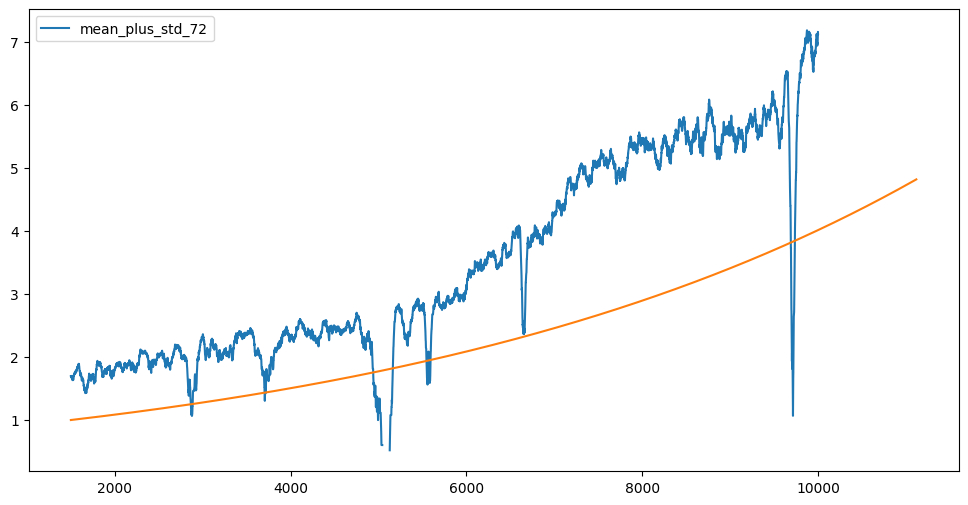

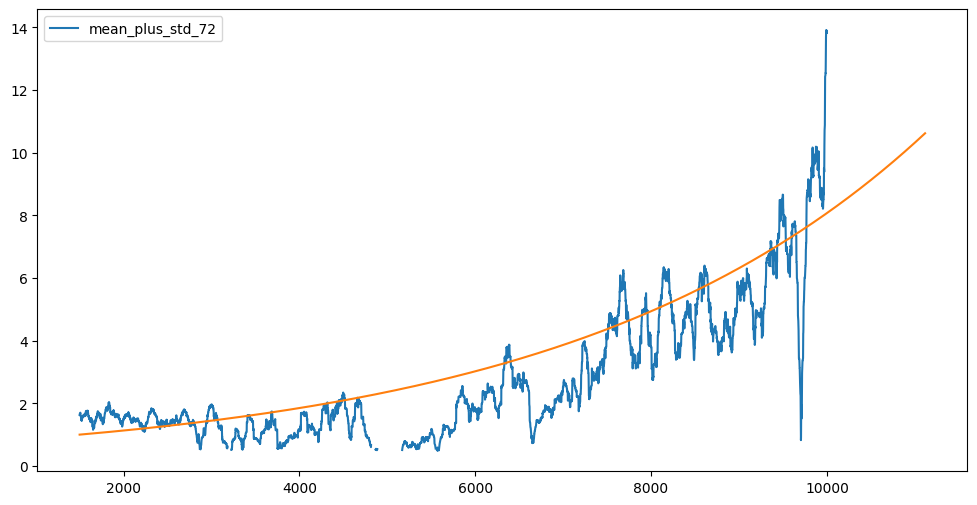

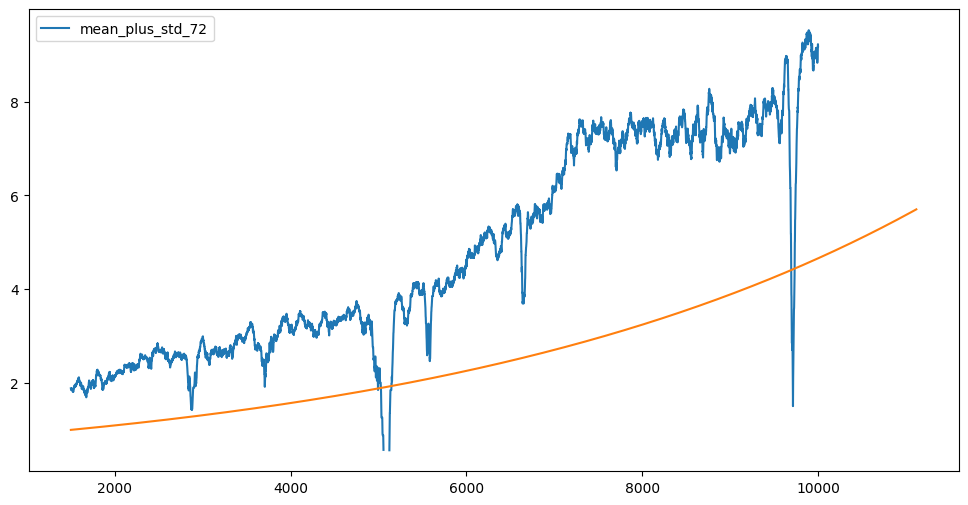

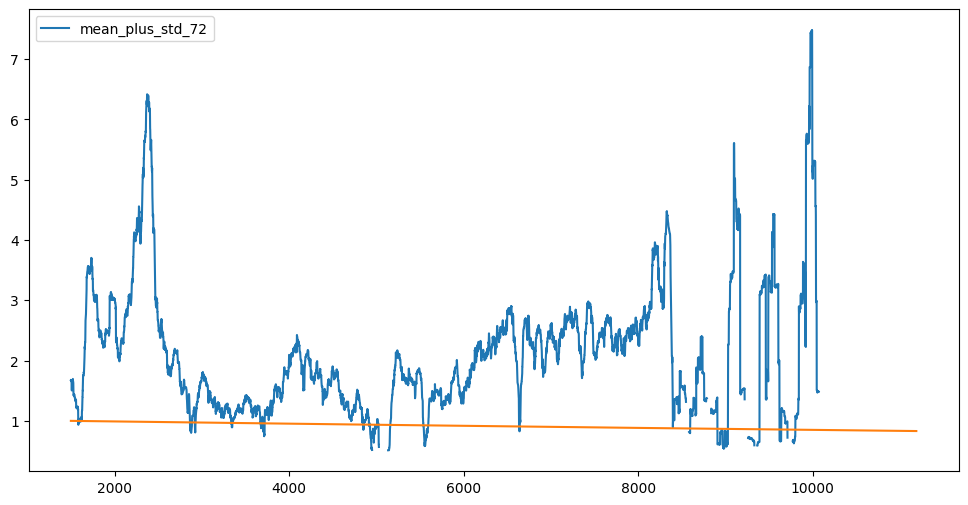

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


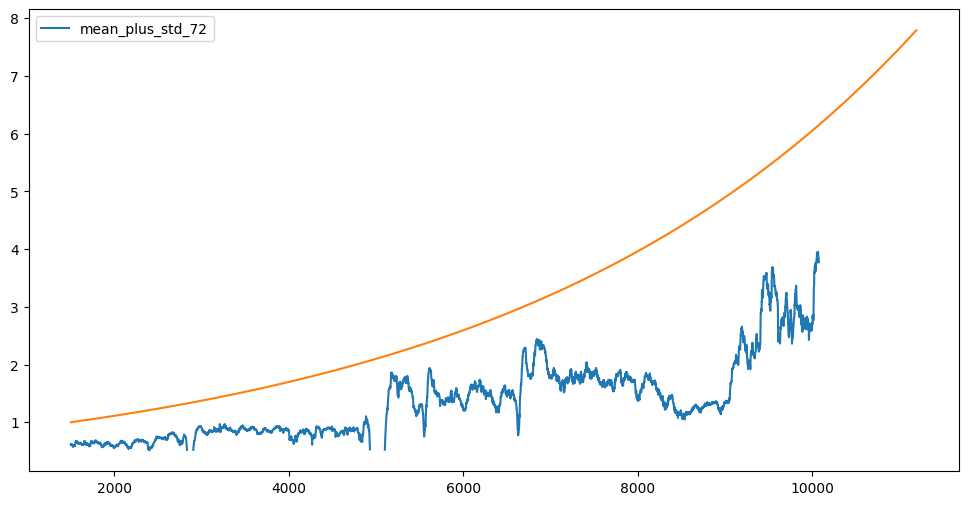

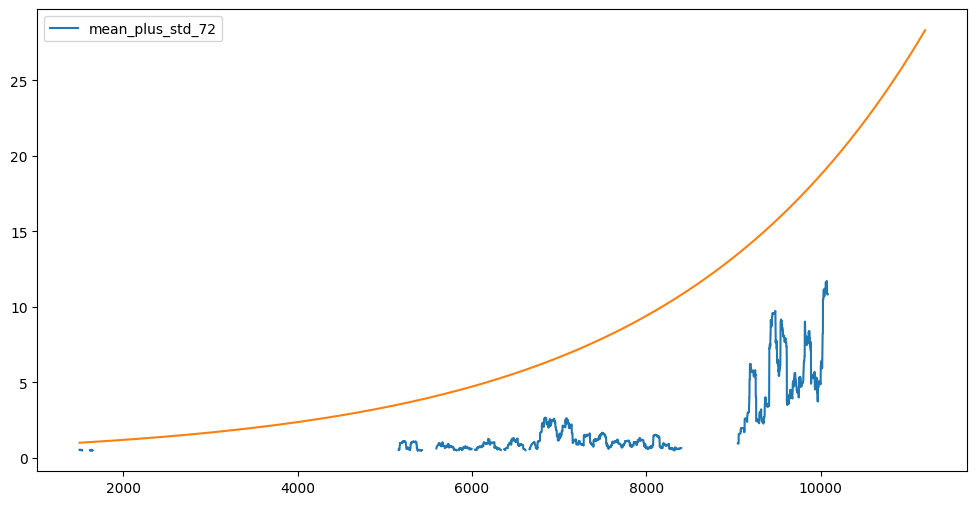

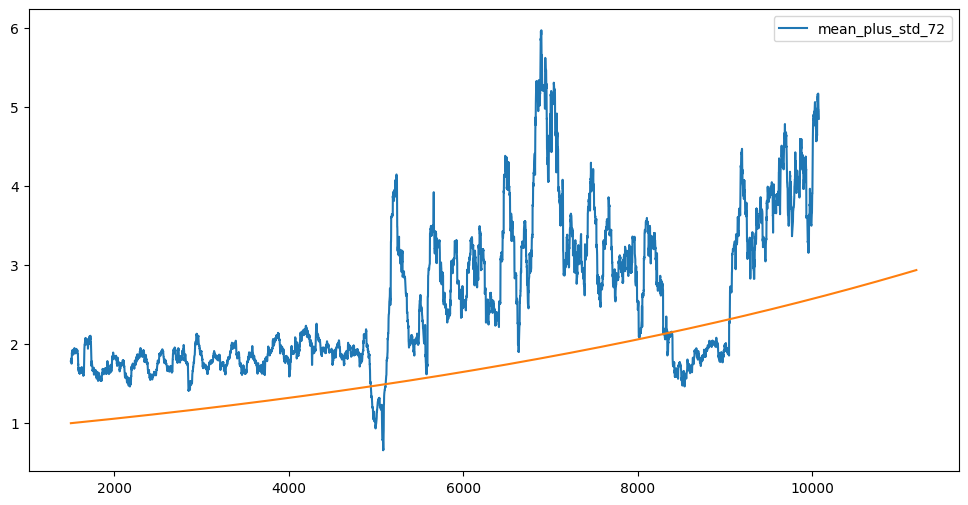

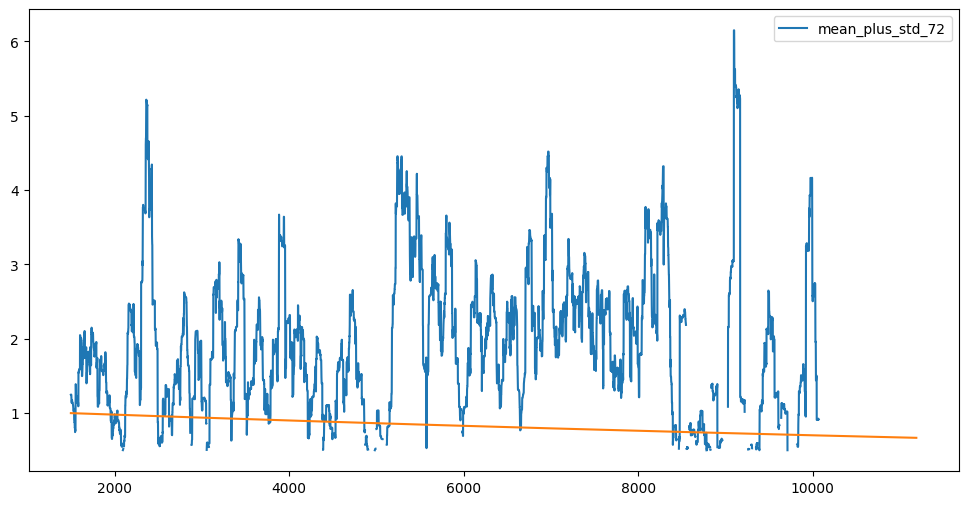

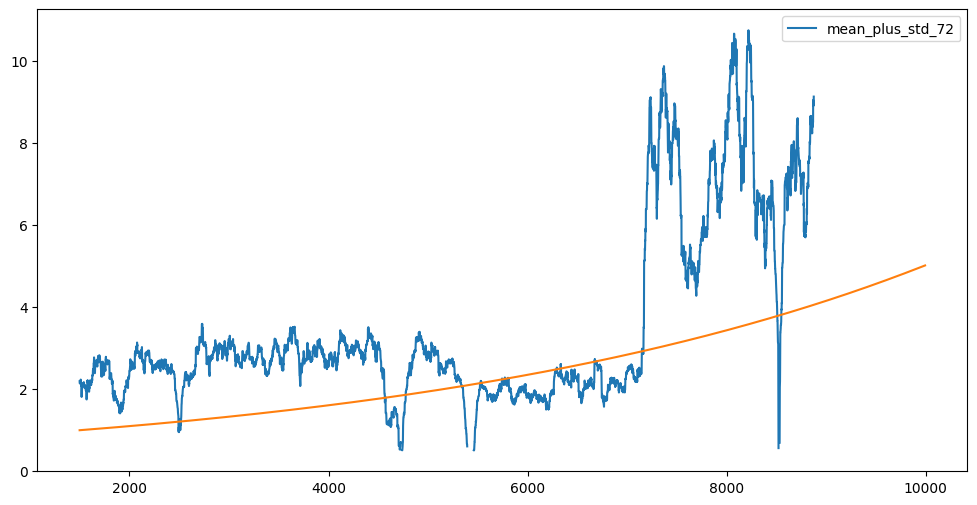

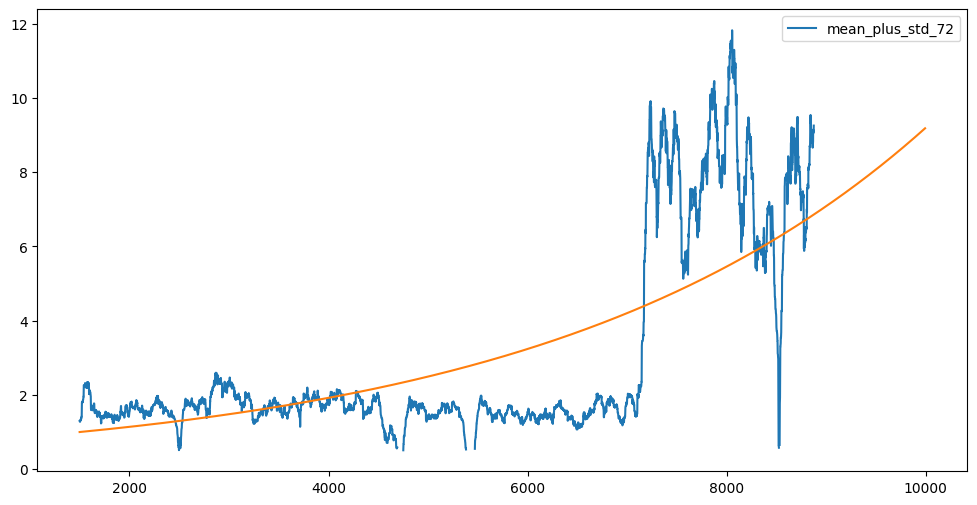

In [47]:
import statsmodels.api as sm
for key, _ in fault_df_dict.items():
# 로그 변환 적용
  data = fault_df_dict[key][["mean_plus_std_72"]][1500:-1177 ]
  data.loc[data['mean_plus_std_72'] < 0.5, 'mean_plus_std_72'] = np.nan
  log_data = np.log(data)

  # 모델 피팅
  model = sm.tsa.statespace.SARIMAX(log_data, order=(0,1,1), trend='c')
  results = model.fit()

  # 예측
  forecast = np.exp(results.predict(start= 0 , end=len(data)+1117, dynamic=True))

  # 예측 결과 시각화
  fig, ax = plt.subplots(figsize=(12, 6))
  data.plot(ax=ax)
  forecast.plot(ax=ax)
  plt.show()

### 전처리 된 데이터 시각화

# 여기서 부터 분석 하십시오

## 분석 대상
#### fault_df_dict : 고장이 탐지되었음
#### normal_df_dict : 고장이 탐지되지 않았음
위 리스트에서 데이터를 꺼내서 쓰시오

## 전처리 내용
1. 이상치 제거
2. 정규화
3. Moving Average/STD

## 목적 : 양성 데이터에 대해 Recall 1.0인 분류기 만들기

# Prophet
시도1

Scalar를 예측 -  예측 잘 안됨

TemporalFusionTransformer 
- 입력시퀀스 2주, 출력시퀀스 4주 

- 학습시간 오래걸림

- 거의 상수함수 형태로 예측 해버림, 성능 나쁨
                  
LSTM(제대로 모델링 했는지 불분명)
- 거의 상수함수 형태로 예측 해버림, 성능 나쁨

ARIMA(MLE 수렴안함 -> 데이터랑 모델이랑 잘 안 맞는다?)
- 성능나쁨(Grid search)

시도2
mean_plus_std_72를 예측 
1. 앞선72개(약2일)의 데이터의 평균 +  1.5 표준편차

2.  plot 해봤더니 어느정도 트렌드를 반영 하는 것 처럼 보임

3.  얘를 예측 해볼까?

4. 약 4주 정도를 남기고 prophet에 피팅(하이퍼 파라미터 튜닝 필요)

다항함수로 regression?, 지수함수?,

In [11]:
from prophet import Prophet
import seaborn as sns
import logging
from tqdm import tqdm

In [12]:
def detect_and_replace_anomalies(dataframe,dates, interval_width=0.8, changepoint_range=0.9):
    
    def fit_predict_model(dataframe, interval_width, changepoint_range):
        
        logging.getLogger('prophet').setLevel(logging.WARNING)
        model = Prophet(interval_width=interval_width, changepoint_range=changepoint_range)
        model.fit(dataframe)
        future = model.make_future_dataframe(periods=0, freq='H')
        forecast = model.predict(future)
        forecast['fact'] = dataframe['y'].reset_index(drop=True)
        return forecast
    
    def detect_anomalies_low(forecast):
        forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
        forecasted['anomaly'] = 0
        forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1
        return forecasted
    
    def detect_anomalies_up(forecast):
        forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
        forecasted['anomaly'] = 0
        forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
        return forecasted
    logging.getLogger('prophet').setLevel(logging.WARNING)
    pred = fit_predict_model(dataframe, interval_width, changepoint_range)
    pred = detect_anomalies_low(pred)
    anomaly = pred.anomaly == 1
    pred.iloc[anomaly, 5] = np.nan
    

    data = pd.DataFrame({'ds': pred['ds'], 'y': pred['fact']})
    model = Prophet(changepoint_range=changepoint_range)
    model.fit(data)
    last = model.predict(dates)

    return model, last



In [13]:
model_dict = {}
forecast_dict = {}
for key, _ in tqdm(fault_df_dict_train.items()):
  
  dataframe = pd.DataFrame({
      'ds' : fault_df_dict_train[key]['DateTime'],
      'y' : fault_df_dict_train[key]['mean_plus_std_72'].rolling(window=3, closed = 'both', min_periods = 1).max()
  })
  dates = pd.DataFrame(pd.concat([fault_df_dict_train[key].DateTime,fault_df_dict_test[key].DateTime],axis = 0).reset_index(drop = True))
  dates.columns = ["ds"]
  a = detect_and_replace_anomalies(dataframe,dates)
  model_dict[key] = a[0]
  forecast_dict[key] = a[1]


  0%|          | 0/13 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4all5i9/jfsr8goa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4all5i9/t5x_uxbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8969', 'data', 'file=/tmp/tmpk4all5i9/jfsr8goa.json', 'init=/tmp/tmpk4all5i9/t5x_uxbq.json', 'output', 'file=/tmp/tmpk4all5i9/prophet_modelsosgnt51/prophet_model-20230514122221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:22:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4all5i9/0tbpojfn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk4all5i9/6qie9mmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:

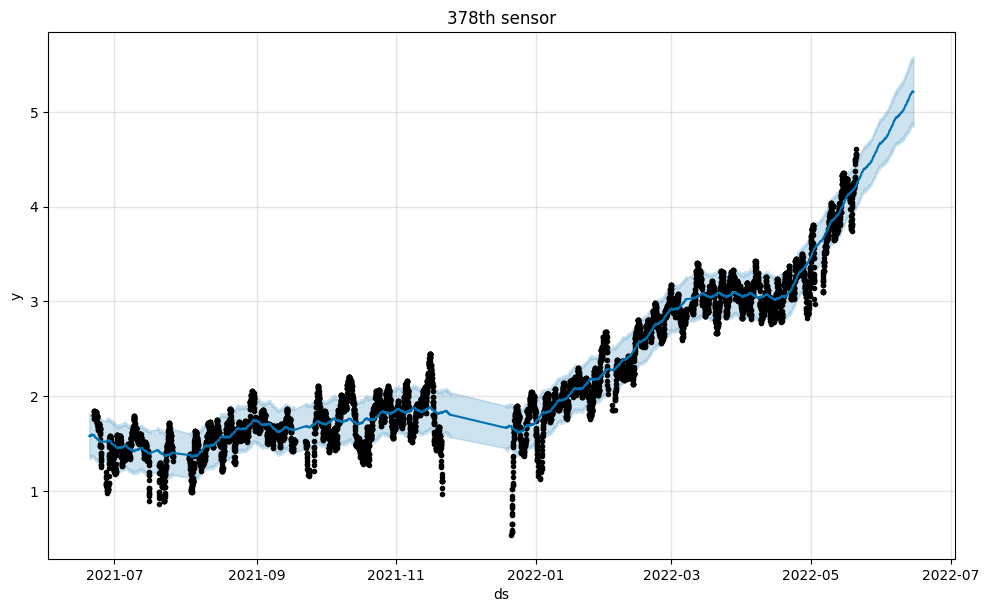

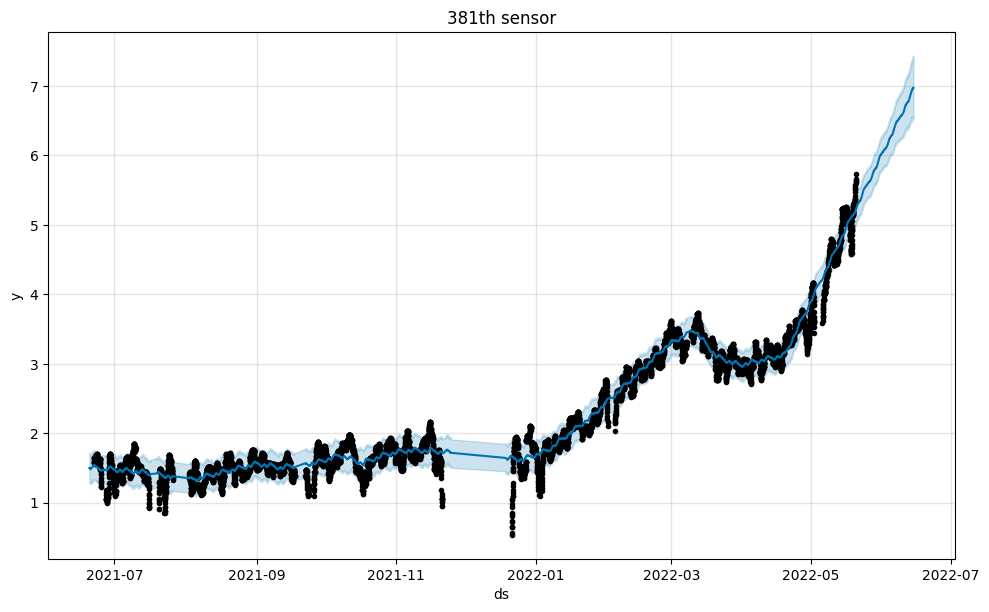

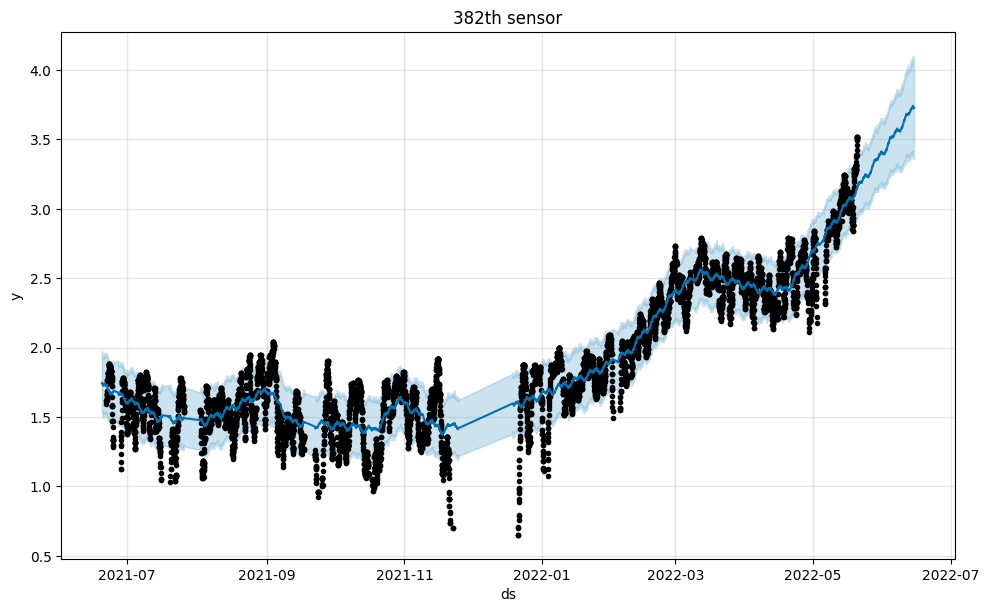

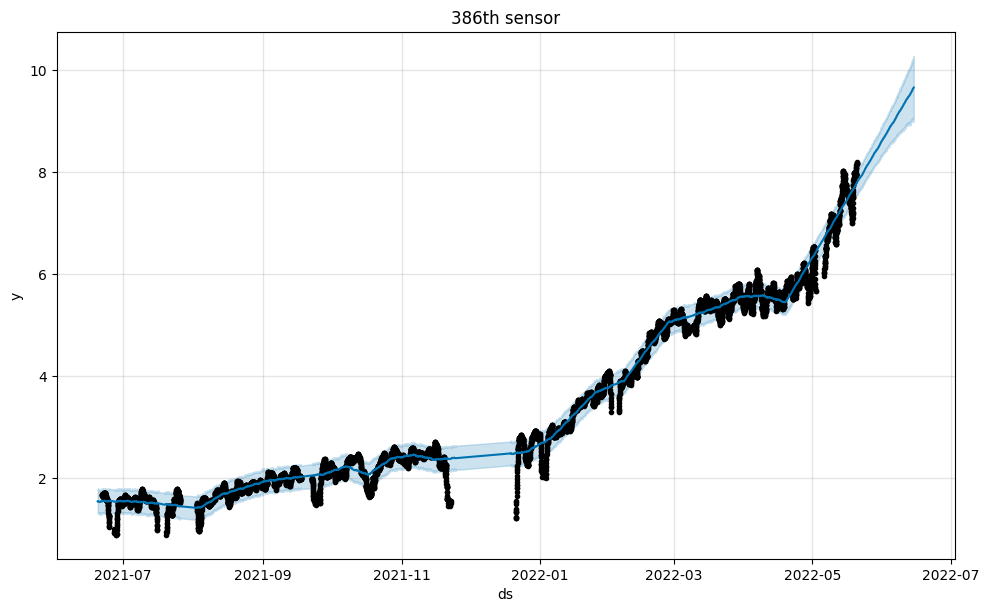

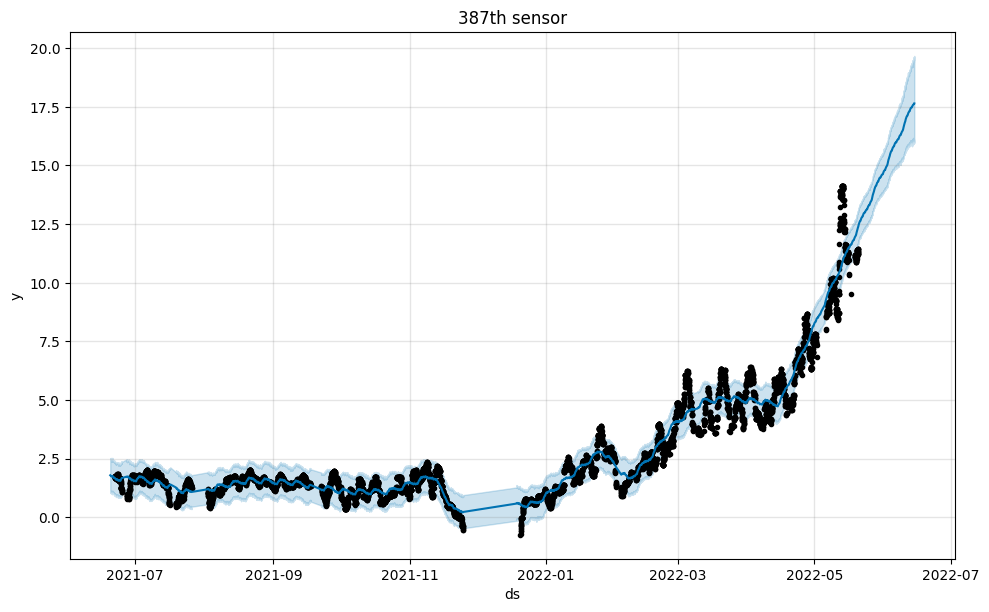

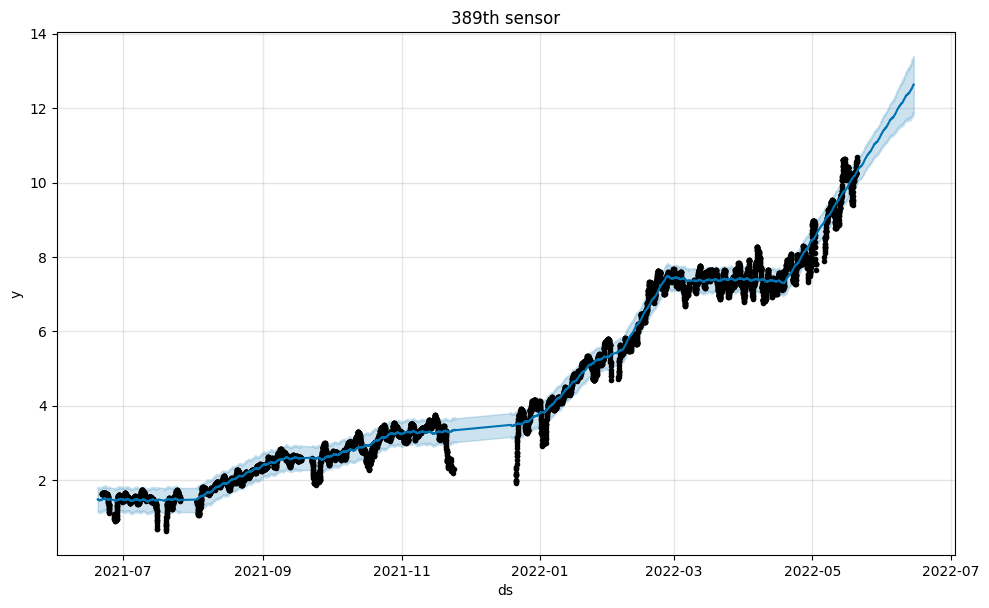

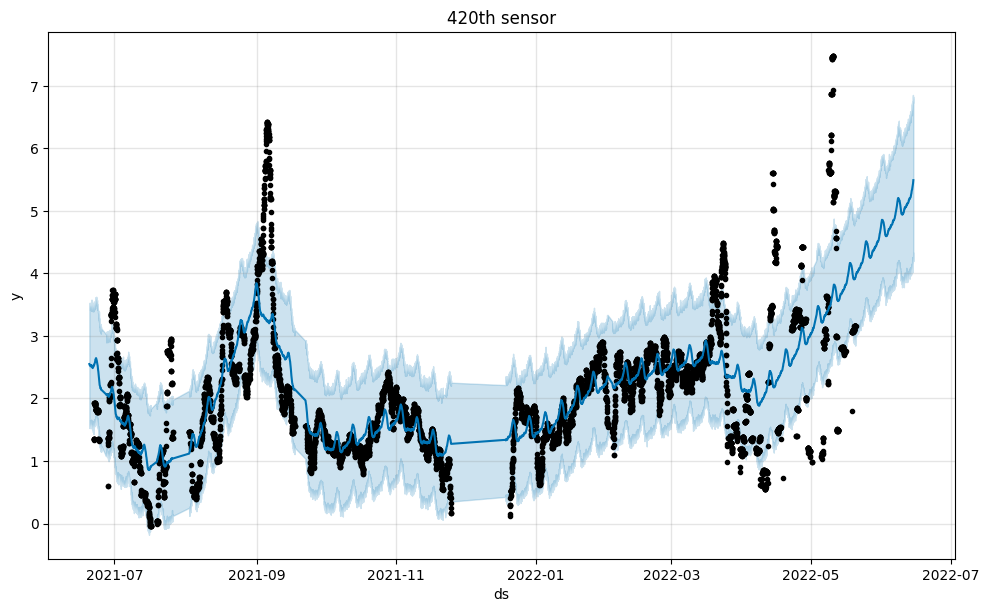

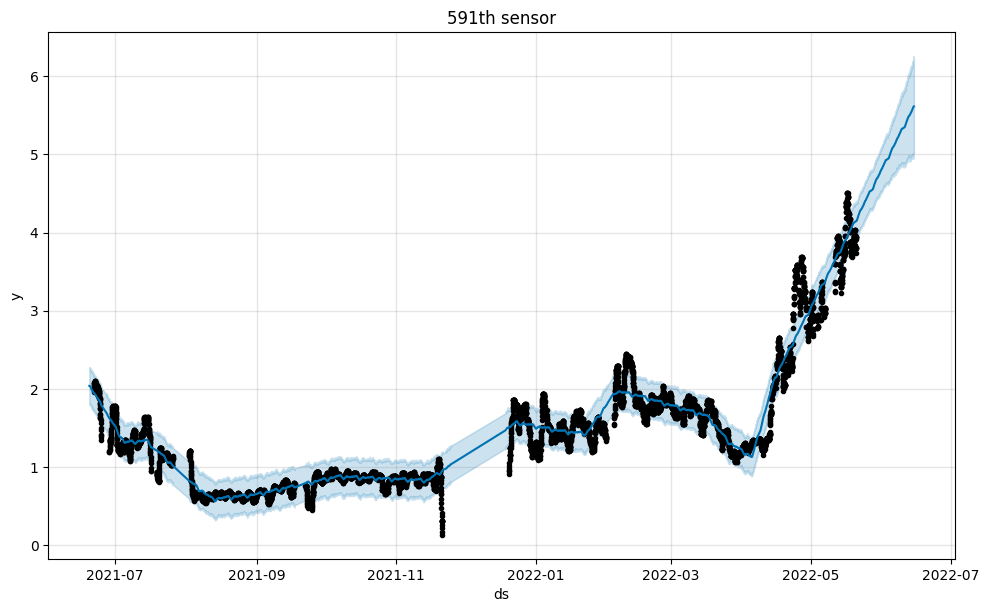

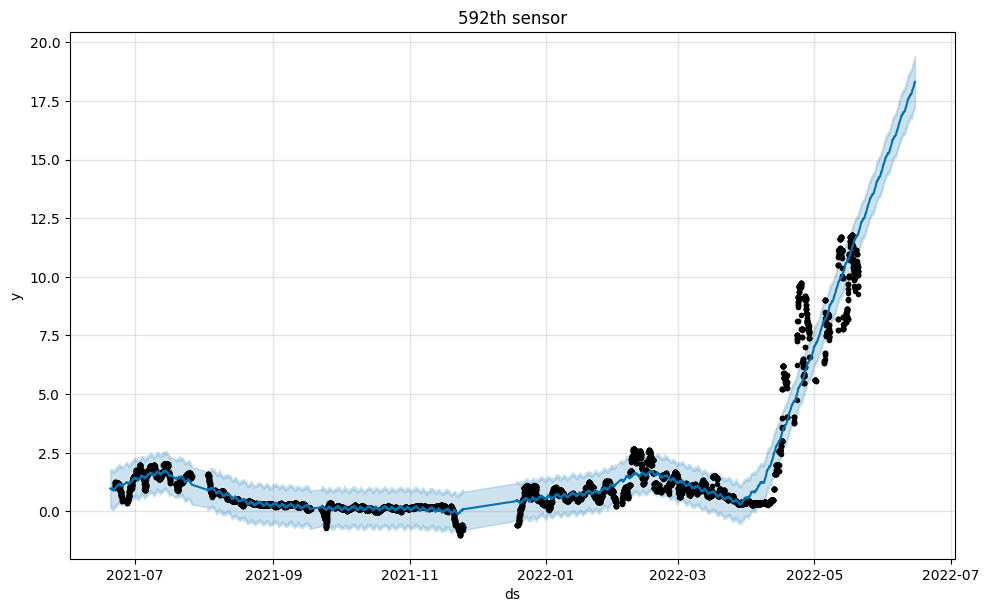

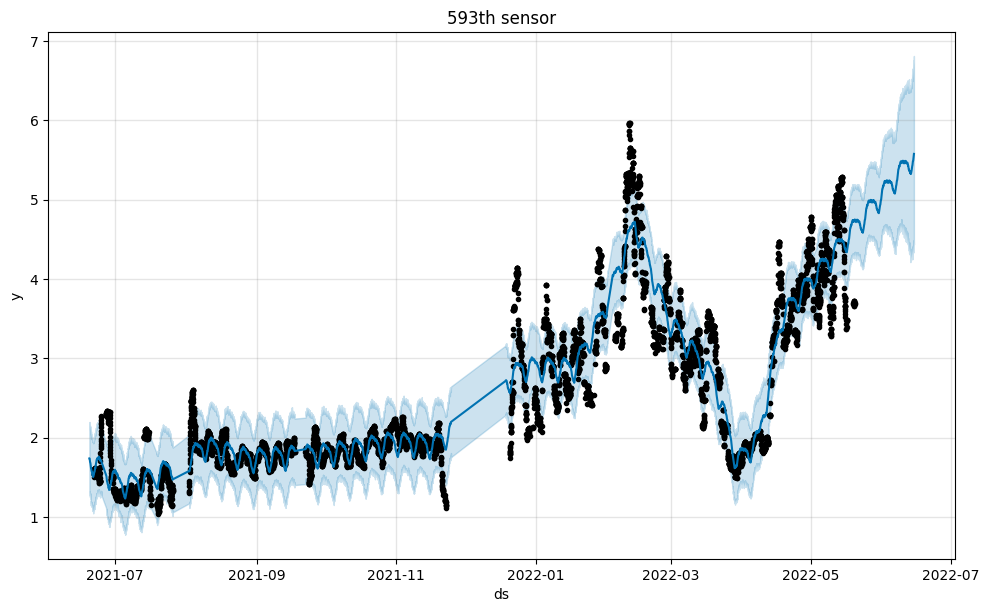

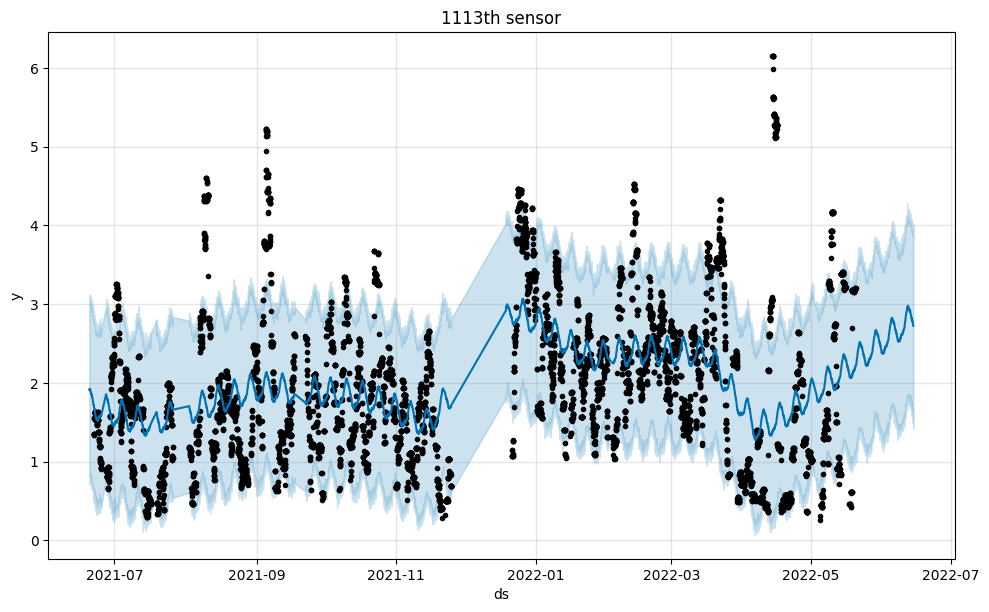

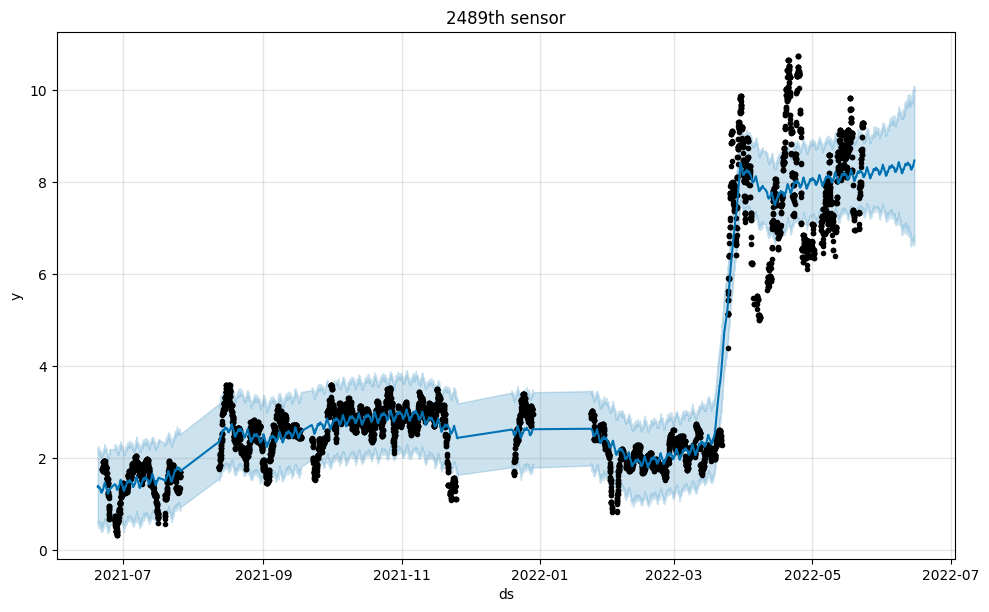

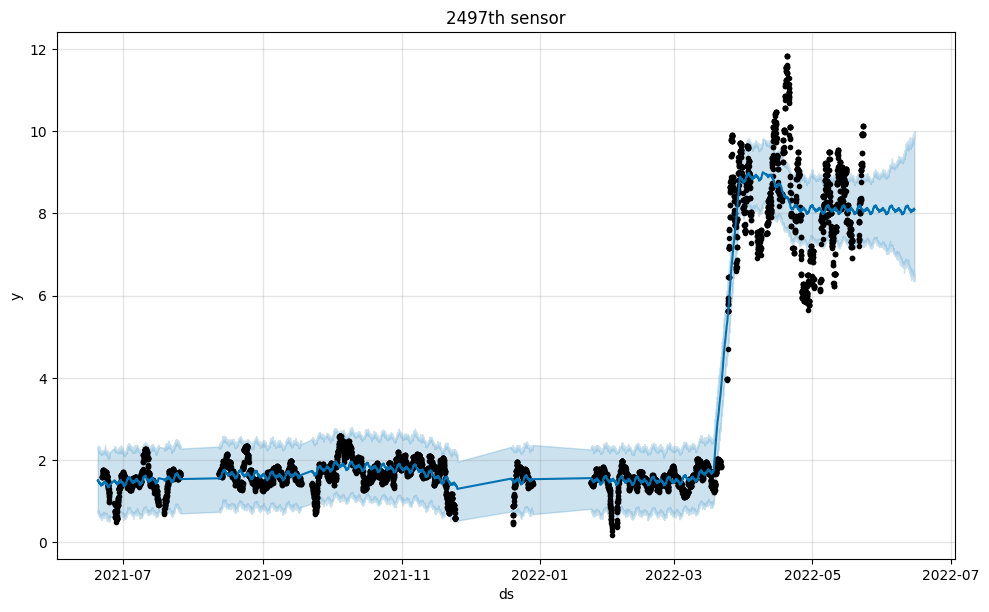

In [14]:
for key, _ in fault_df_dict_train.items():
  fig = model_dict[key].plot(forecast_dict[key], plot_cap=False)
  ax = fig.gca() 
  ax.set_title('{}th sensor'.format(key))

In [15]:
for key, _ in fault_df_dict_train.items():
  fault_df_dict[key] = fault_df_dict[key].rename({"DateTime":"ds"},axis = 1)
  fault_df_dict[key] = pd.merge(fault_df_dict[key], forecast_dict[key][["ds","trend","yhat_lower","yhat_upper","yhat"]],on = "ds")
  fault_df_dict[key] = fault_df_dict[key].reset_index(drop=True)
  fault_df_dict[key]['time_idx']=fault_df_dict[key].index

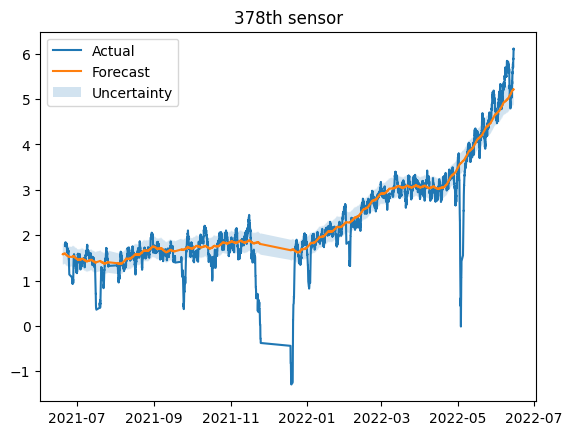

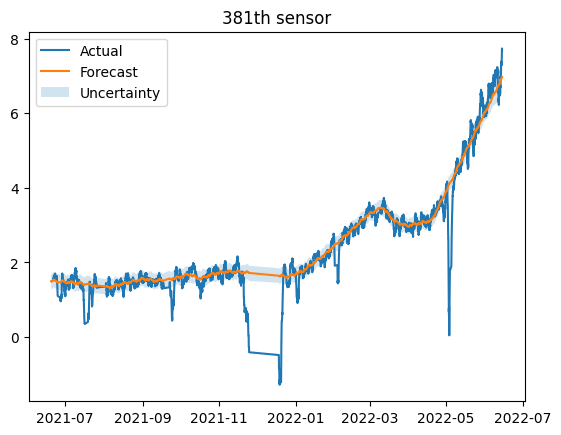

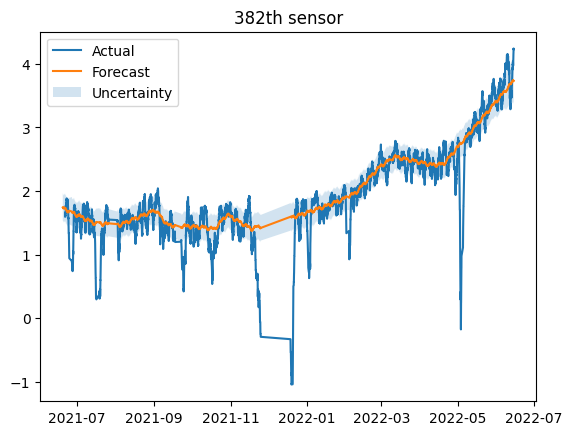

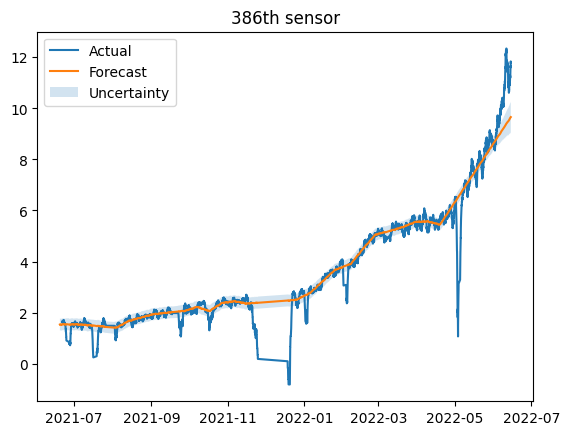

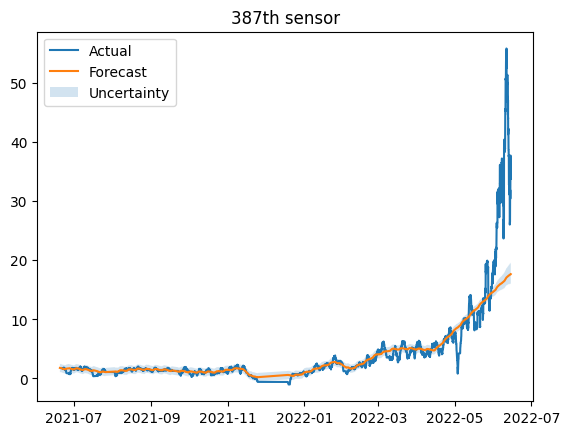

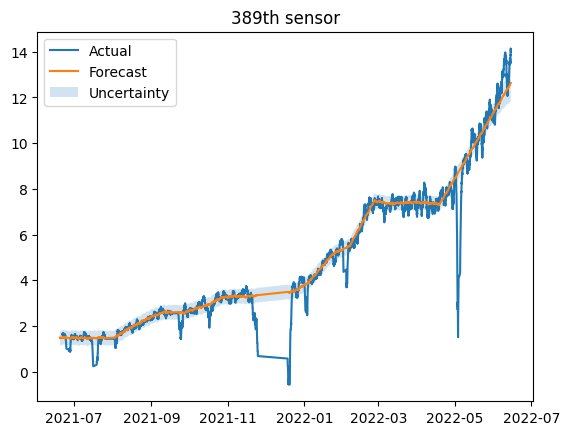

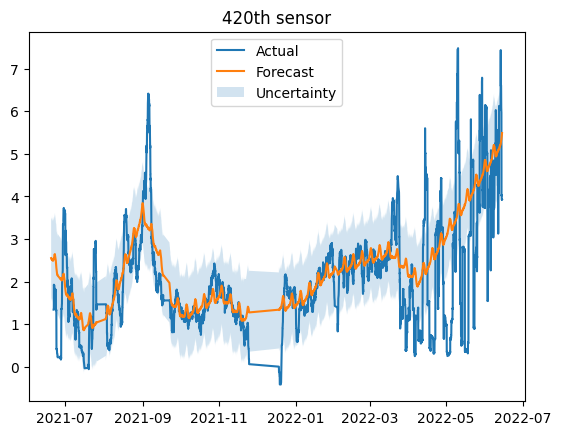

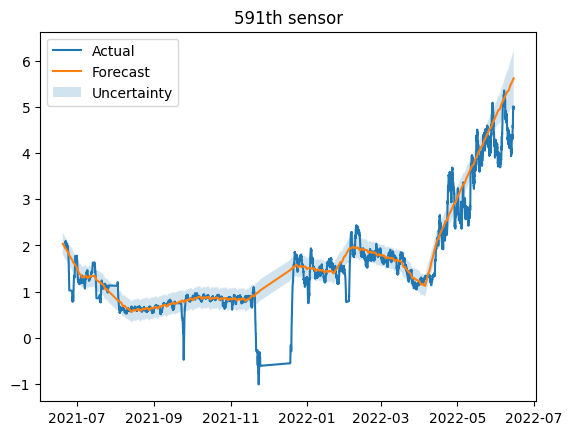

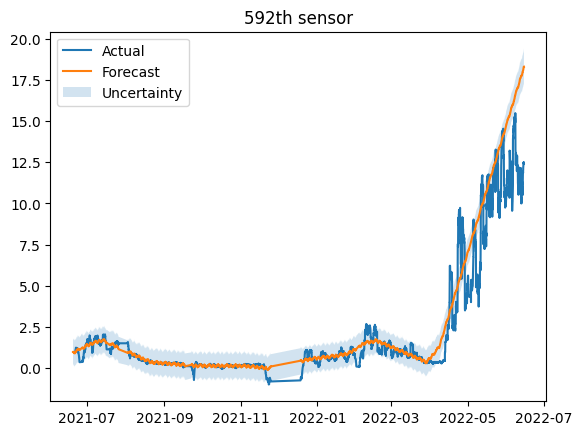

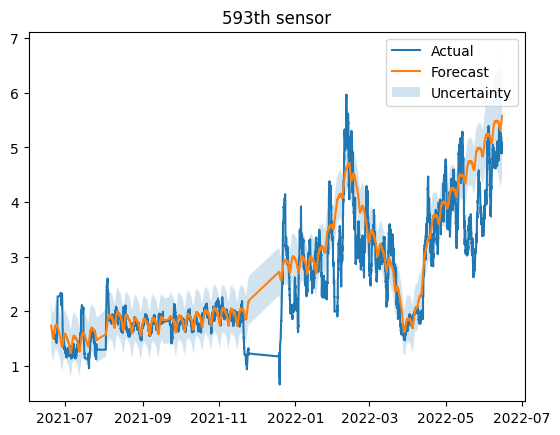

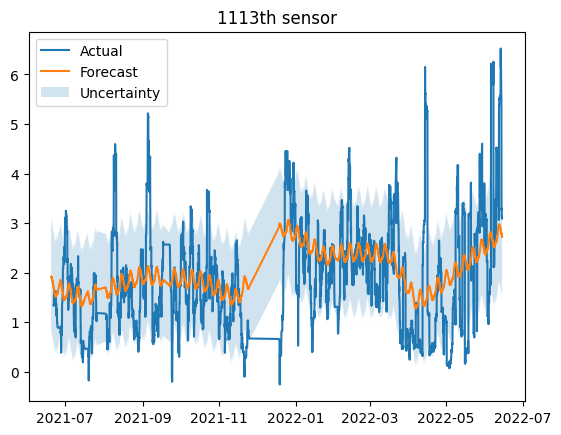

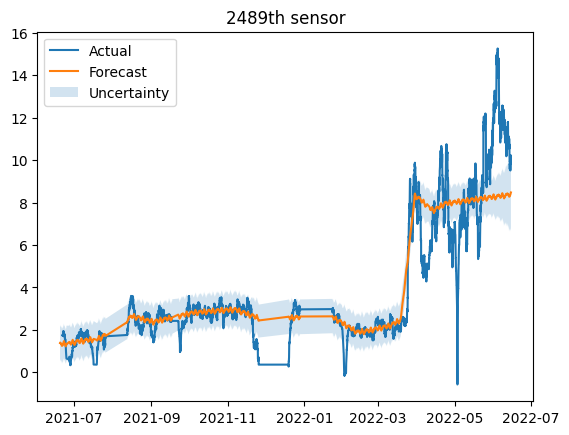

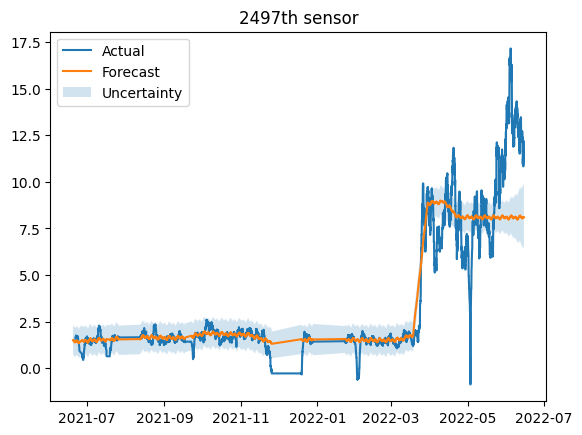

In [16]:

for key, _ in fault_df_dict_train.items():
    fig, ax = plt.subplots()
    ax.plot(fault_df_dict[key]["ds"], fault_df_dict[key]["mean_plus_std_72"], label="Actual")
    ax.plot(forecast_dict[key]["ds"], forecast_dict[key]["yhat"], label="Forecast")
    ax.fill_between(forecast_dict[key]["ds"], forecast_dict[key]["yhat_upper"], forecast_dict[key]["yhat_lower"], alpha=0.2, label="Uncertainty")
    ax.set_title("{}th sensor".format(key))
    ax.legend()
    plt.show()


# TFT(X 실험용 XXXX)

In [17]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import torch
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from lightning.pytorch.tuner import Tuner

In [19]:
data = fault_df_dict[378][6500:].drop(["Idx"],axis = 1)

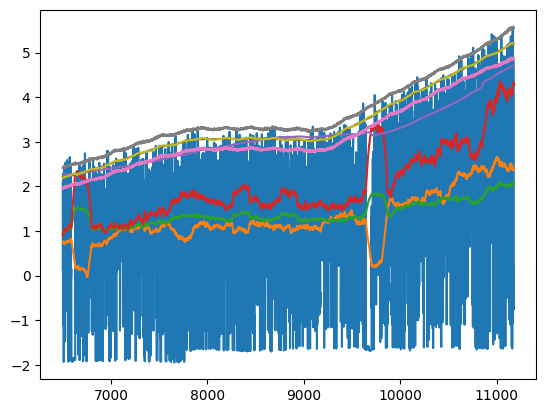

In [20]:
plt.plot(data[["Scalar","ma168",	"std168",	"var168",	"upper_envolope_ma48","trend","yhat_lower","yhat_upper","yhat"]])

[]

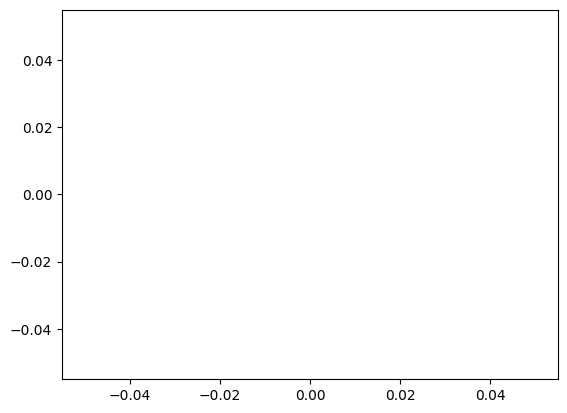

In [21]:
plt.plot()

In [22]:
max_prediction_length = 1000
max_encoder_length = 500
training_cutoff = data["time_idx"].max() - 1000
data["MeasureId"] = data["MeasureId"].astype(str).astype("category")
test = data[-1500:]
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="upper_envolope_ma48",
    group_ids=["MeasureId"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["MeasureId"],
    static_reals=[],
    time_varying_known_categoricals=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx","yhat",'trend', 'yhat_lower', 'yhat_upper'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["ma168","std168","var168","Scalar"],
    target_normalizer=None,  
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)
# load the test data into a TimeSeriesDataSet object
test_data = test  # replace this with your own function to load test data
test = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

# create a dataloader for the test set
test_dataloader = test.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [23]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="gpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 11.6k


In [24]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 26.0k


In [25]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1     
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.6 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initia

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
tft.predict(val_dataloader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor([[3.2959, 3.2806, 3.2795, 3.2859, 3.2959, 3.3064, 3.3157, 3.3229, 3.3290,
         3.3341, 3.3373, 3.3396, 3.3423, 3.3435, 3.3448, 3.3464, 3.3466, 3.3475,
         3.3476, 3.3482, 3.3483, 3.3486, 3.3489, 3.3490, 3.3490, 3.3488, 3.3489,
         3.3493, 3.3495, 3.3492, 3.3492, 3.3493, 3.3495, 3.3500, 3.3498, 3.3495,
         3.3494, 3.3498, 3.3495, 3.3497, 3.3497, 3.3501, 3.3500, 3.3498, 3.3501,
         3.3502, 3.3501, 3.3503, 3.3500, 3.3503, 3.3501, 3.3501, 3.3504, 3.3503,
         3.3504, 3.3503, 3.3501, 3.3504, 3.3503, 3.3504, 3.3506, 3.3503, 3.3504,
         3.3504, 3.3501, 3.3502, 3.3502, 3.3505, 3.3506, 3.3502, 3.3507, 3.3501,
         3.3502, 3.3504, 3.3503, 3.3503, 3.3505, 3.3505, 3.3508, 3.3502, 3.3505,
         3.3503, 3.3502, 3.3505, 3.3502, 3.3504, 3.3501, 3.3506, 3.3506, 3.3504,
         3.3508, 3.3507, 3.3505, 3.3507, 3.3504, 3.3506, 3.3511, 3.3506, 3.3508,
         3.3509, 3.3508, 3.3506, 3.3506, 3.3510, 3.3510, 3.3508, 3.3503, 3.3506,
         3.3504, 3.3507, 3.3

In [27]:
tft.plot_prediction(val_dataloader)

TypeError: ignored

In [ ]:
result = tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions, x = result[0], result[1]


In [ ]:
for idx in range(1):  # plot examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);